In [2]:
from flymazerl.agents.neuralnetworks import GQLearner, GRNNLearner
from flymazerl.gym.environment import ymaze_static
from itertools import product
import torch

import pandas as pd
import numpy as np
import os
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib as mpl


mpl.rcParams.update(mpl.rcParamsDefault)

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [ ]:
full_data = pd.DataFrame()
for folder in tqdm(os.listdir()):
    # check if folder is a directory
    if not os.path.isdir(folder):
        continue
    # load params.json from each folder
    with open(os.path.join(folder, 'params.json')) as f:
        params = json.load(f)
    # load data from each folder
    try:
        data = pd.read_csv(os.path.join(folder, 'results.csv.gz'), compression='gzip')
    except FileNotFoundError:
        continue
    # att remaining params to data
    keys = [i for i in params.keys() if i not in ['save_path', 'action_set_data', 'reward_set_data','n_ensemble','print_every']]
    for key in keys:
        if key == 'hidden_state_sizes':
            data[key] = 'x'.join(map(str, params[key]))
        else:
            data[key] = params[key]
    # append to full_data
    full_data = pd.concat([full_data, data], ignore_index=Tru
full_data.to_pickle('full_data.pkl')

In [3]:
full_data = pd.read_pickle('../../../modelfits/nn/full_data.pkl')

In [4]:
full_data.columns

Index(['ModelID', 'EnsembleID', 'FoldID', 'FlyID', 'MSE(train)', 'NMSE(train)',
       'LogLikelihood(train)', 'AIC(train)', 'BIC(train)', 'MSE(test)',
       'NMSE(test)', 'LogLikelihood(test)', 'AIC(test)', 'BIC(test)',
       'P(action)', 'Model Path', 'Training Loss', 'Validation Loss',
       'Best Validation Loss', 'Epochs', 'Best Validation Epoch',
       'Training Time', 'agent', 'n_folds', 'history_size', 'max_epochs',
       'early_stopping', 'learning_rate', 'weight_decay', 'train_test_split',
       'reservoir_size', 'num_reservoirs', 'encoder_size', 'kind',
       'hidden_state_sizes', 'activation', 'policy_type', 'device',
       'symmetric', 'allow_negative', 'omission_is_punishment'],
      dtype='object')

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\scipy\stats\stats.py:2857: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  pct = percentile_func(x, rng, axis=axis, interpolation=interpolation,
c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

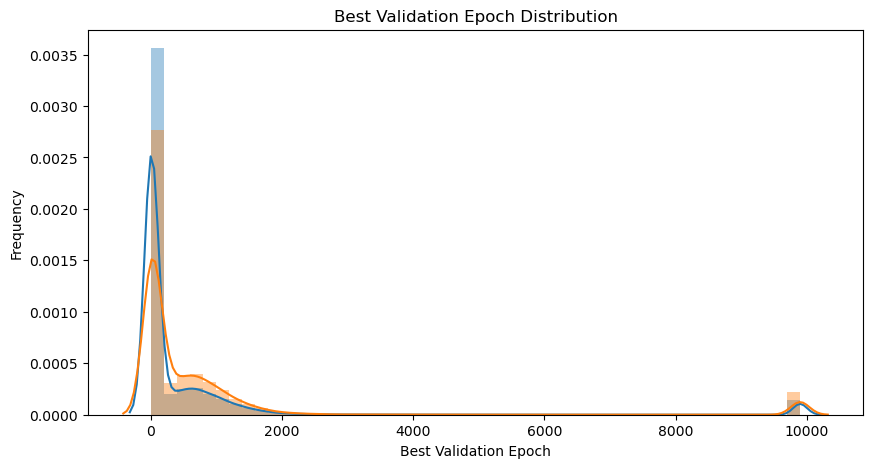

In [5]:
# plot a histogram of the best validation epochs
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(full_data['Best Validation Epoch'], ax=ax)

# backup full_data
full_data_backup = full_data.copy()

# filter out the data that had the first epoch as the best validation epoch
full_data = full_data[full_data['Best Validation Epoch'] != 0]

sns.distplot(full_data['Best Validation Epoch'], ax=ax)
ax.set_xlabel('Best Validation Epoch')
ax.set_ylabel('Frequency')
ax.set_title('Best Validation Epoch Distribution')
plt.show()

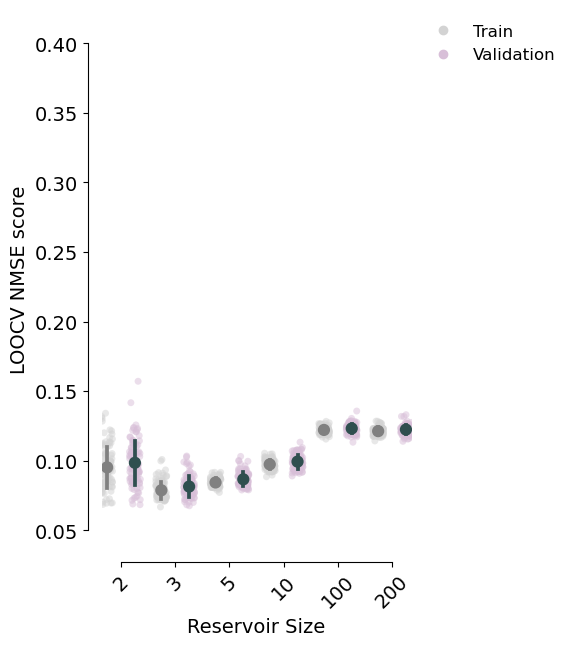

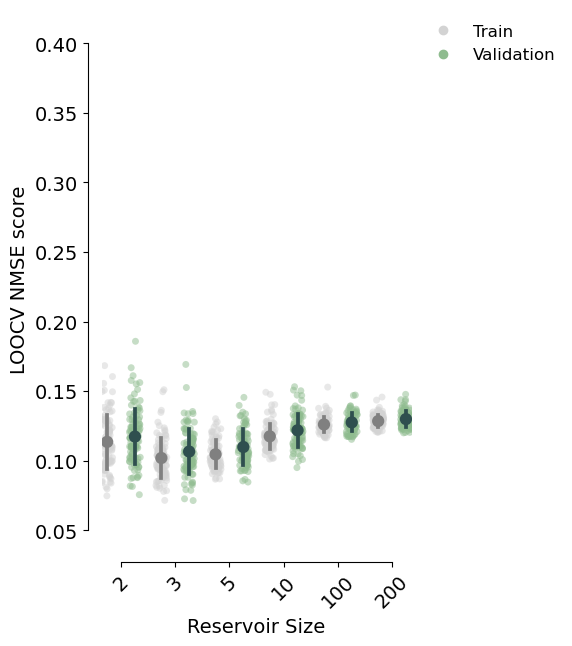

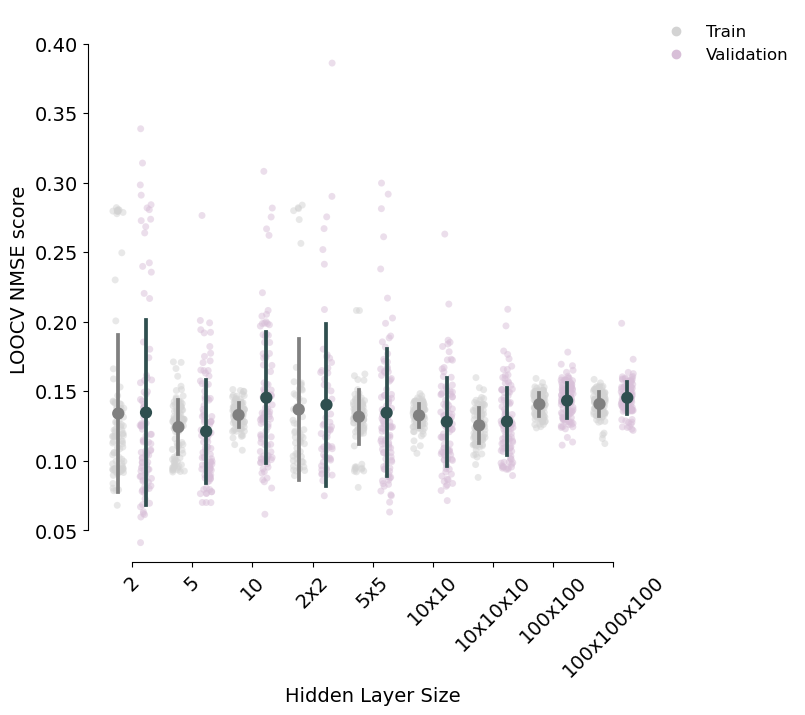

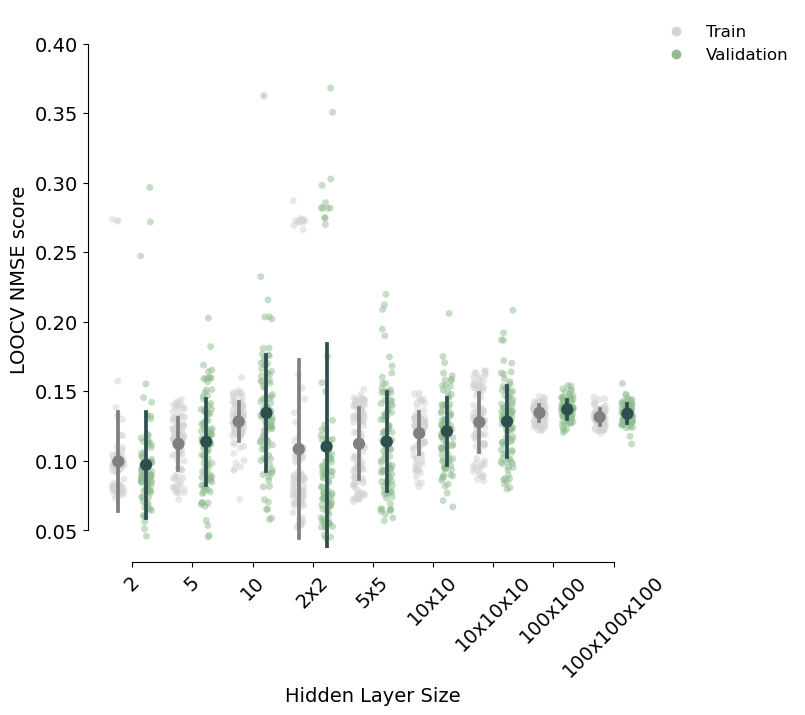

In [5]:
metric = "NMSE" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"

reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(4,7) if agent == "GRNN" else (7,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color='lightgrey', ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)
        offset = transforms.ScaledTranslation(-20/72, 0, fig.dpi_scale_trans)
        for i in ax.collections:
            trans = i.get_transform()
            i.set_transform(trans + offset)
        for i in ax.lines:
            trans = i.get_transform()
            i.set_transform(trans + offset)

        # plot testing error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order= order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, join=False, ci='sd',color='darKslategray', ax=ax, order=order)
        offset = transforms.ScaledTranslation(10/72, 0, fig.dpi_scale_trans)
        for i in ax.collections:
            trans = i.get_transform()
            i.set_transform(trans + offset)
        for i in ax.lines:
            trans = i.get_transform()
            i.set_transform(trans + offset)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # create empty markers for legend
        ax.plot([], [], 'o', color='lightgrey', label="Train")
        ax.plot([], [], 'o', color=color, label="Validation")
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
        # remove legend frame
        legend.set_frame_on(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"LOOCV {metric} score")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
        plt.show()


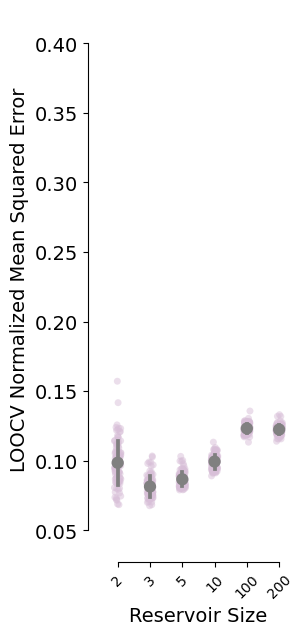

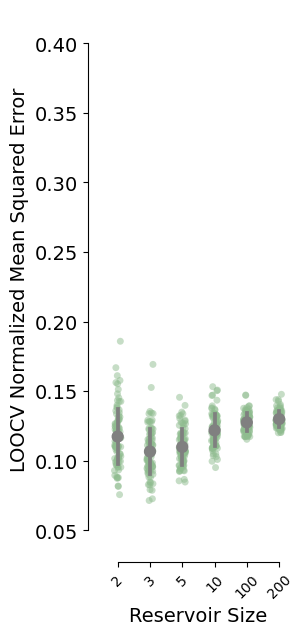

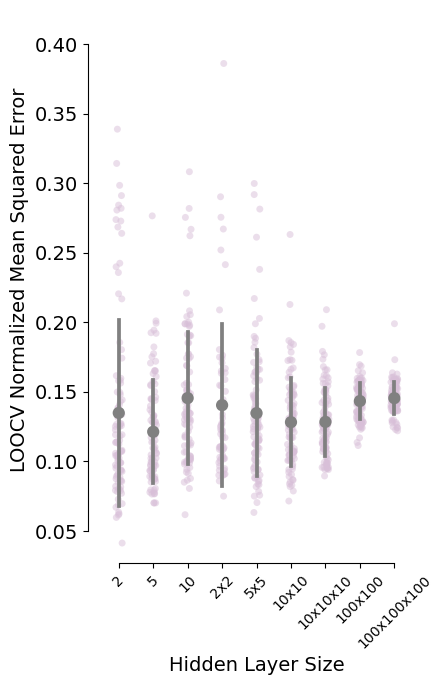

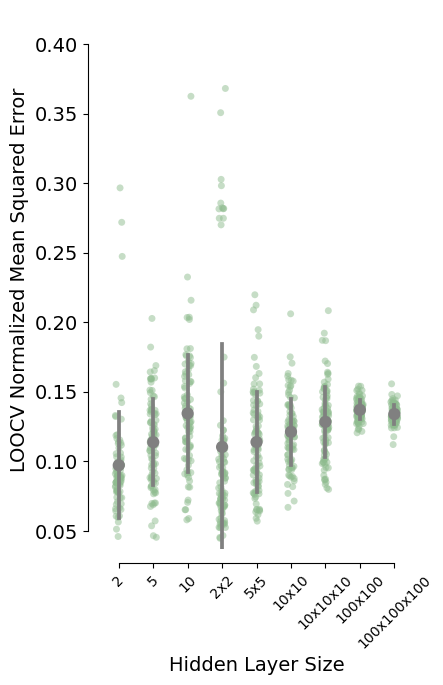

In [6]:
metric = "NMSE" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"
metric_map = {"MSE":"Mean Squared Error", "NMSE":"Normalized Mean Squared Error", "LogLikelihood":"Log Likelihood", "AIC":"Akaike Information Criterion", "BIC":"Bayesian Information Criterion"}
reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(2.5,7) if agent == "GRNN" else (4,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(test)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"LOOCV {metric_map[metric]}")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)
        # reduce fontsize of x-axis labels
        plt.setp(ax.get_xticklabels(), fontsize=10)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}_full_version.pdf", bbox_inches='tight')
        plt.show()


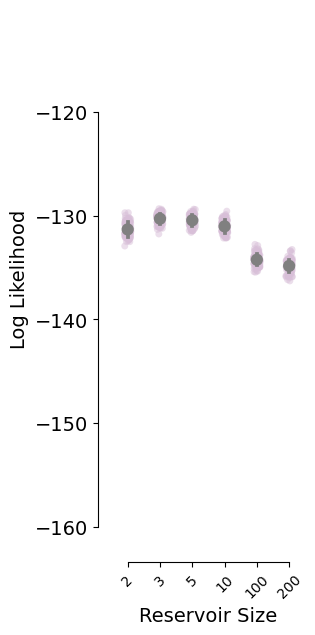

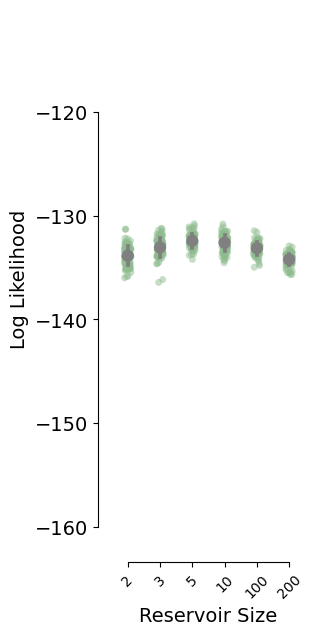

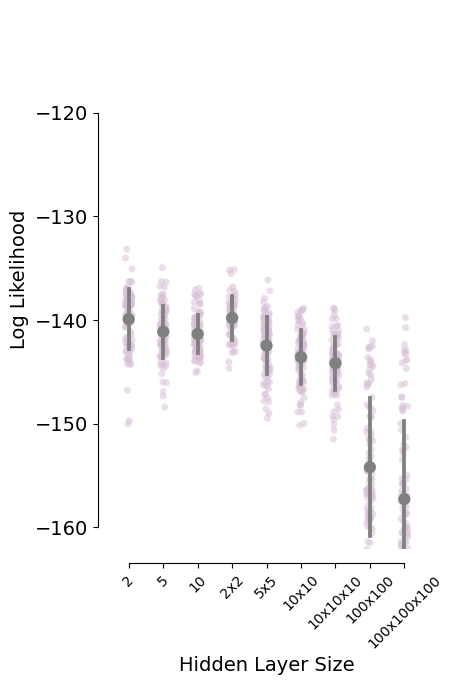

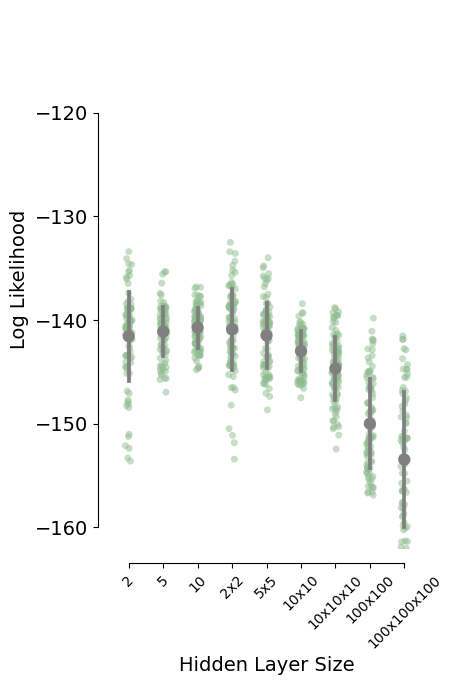

In [7]:
metric = "LogLikelihood" # "MSE" or "NMSE" or "LogLikelihood" or "AIC" or "BIC"
metric_map = {"MSE":"Mean Squared Error", "NMSE":"Normalized Mean Squared Error", "LogLikelihood":"Log Likelihood", "AIC":"Akaike Information Criterion", "BIC":"Bayesian Information Criterion"}
reduced_data = full_data.groupby(['ModelID','EnsembleID']).mean().reset_index()

# find the minimum value of the metric
min_val = min(reduced_data[f"{metric}(train)"].min(), reduced_data[f"{metric}(test)"].min())
# find the maximum value of the metric
max_val = max(reduced_data[f"{metric}(train)"].max(), reduced_data[f"{metric}(test)"].max())

for agent in ["GRNN", "GQNN"]:
    for sym in [True,False]:
        # set fontsize
        plt.rcParams.update({'font.size': 14})

        sub_df = full_data[full_data['agent'] == agent]
        sub_df = sub_df[sub_df['symmetric'] == sym]
        sub_df = sub_df.groupby(['ModelID','EnsembleID']).agg({'{}(train)'.format(metric):'mean', '{}(test)'.format(metric):'mean', 'reservoir_size':lambda x: x.iloc[0], 'hidden_state_sizes':lambda x: x.iloc[0]}).reset_index()

        fig, ax = plt.subplots(figsize=(2.5,7) if agent == "GRNN" else (4,7))

        var = "hidden_state_sizes" if agent == "GQNN" else "reservoir_size"
        order = [2,3,5,10,100,200] if agent == "GRNN" else ['2','5','10','2x2','5x5','10x10','10x10x10','100x100','100x100x100']

        # plot training error
        color = "thistle" if sym else "darkseagreen"
        sns.stripplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, jitter=True, color=color, ax=ax, size=5, alpha=0.5, order=order)
        plt.setp(ax.lines, zorder=-100)
        plt.setp(ax.collections, zorder=-100, label="")
        sns.pointplot(x=var, y=f'{metric}(train)', data=sub_df, dodge=True, join=False, ci='sd',color='grey', ax=ax, order=order)


        # set axis properties
        ax.set_ylim(0.9*min_val, 1.1*max_val)
        # remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # make left and bottom spines invisible
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        # set x-axis and y-axis labels
        ax.set_xlabel("Reservoir Size" if agent == "GRNN" else "Hidden Layer Size", fontsize=14)
        ax.set_ylabel(f"{metric_map[metric]}")
        # despine
        sns.despine(offset=10, trim=True);
        # rotate x-axis labels
        plt.setp(ax.get_xticklabels(), rotation=45)
        # reduce fontsize of x-axis labels
        plt.setp(ax.get_xticklabels(), fontsize=10)

        # save as vector graphic
        plt.savefig(f"../figures/NN-analysis/{agent}_{metric}_{'symmetric' if sym else 'asymmetric'}.pdf", bbox_inches='tight')
        plt.show()


Loading model from //dm11/turnerlab/Rishika/modelfits/nn/softmax/GQNN_5_relu_acceptreject_symmetric_qpn_no-punishment_2022_06_17_20_09_41_614064/ensemble_0_fold_0.pt


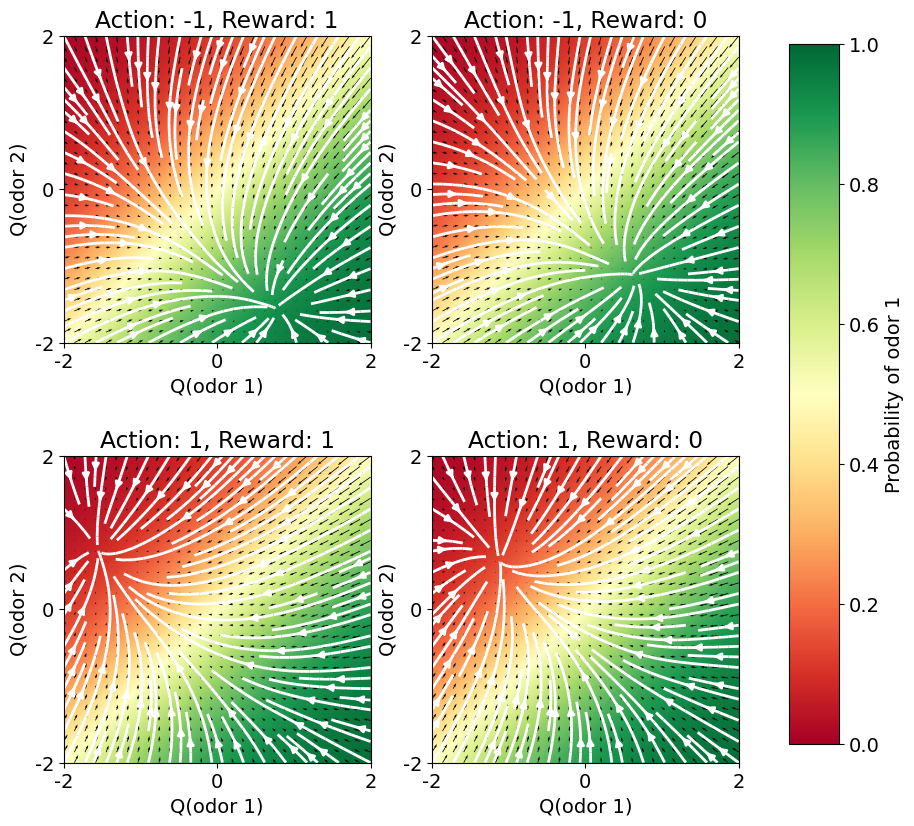

In [77]:
index = 0
resolution = 100
max_q = 5

entry = full_data.iloc[index]
model_id = entry['ModelID']
model_type = entry['agent']
path = entry['Model Path']
model_path = f"//dm11/turnerlab/Rishika/modelfits/nn/softmax/{model_id}/{path}.pt"

env = ymaze_static(100, 0.5)

# create learner parameters
learner_params = {
    "allow_negative_values": True,
    "symmetric_q_function": entry['symmetric'],
    "omission_is_punishment": False,
    "policy_type": 'softmax',
    "device": 'cpu',
    "pre_trained": False,
    "model_path": None,
    "multi_agent": False,
    "n_agents": 1,
}
if entry.agent == "GQNN":
    learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
    learner_params["activation"] = "relu"
    learner = GQLearner(env,learner_params)
elif entry.agent == "GRNN":
    learner_params["encoder_size"] = None
    learner_params["num_layers"] = 1
    learner_params["reservoir_size"] = int(entry.reservoir_size)
    learner_params["kind"] = 'RNN'
    learner = GRNNLearner(env, learner_params)

# load model
print(f"Loading model from {model_path}")
learner.load_pre_trained_model(model_path)


omission = -1 if learner.omission_is_punishment else 0

q_grid = np.array(list(product(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution))))
X_data = []
y_data = []

# create a subplot with a 2x2 grid
fig, ax = plt.subplots(2,2,figsize=(10,10))

for count,action_reward_pair in zip(range(4),[[-1,1],[-1,omission],[1,1],[1,omission]]):

    with torch.no_grad():
        q = learner.agent.forward(torch.tensor(np.repeat([action_reward_pair],q_grid.shape[0],axis=0),dtype=torch.float),torch.tensor(q_grid,dtype=torch.float)).cpu()-torch.tensor(q_grid,dtype=torch.float)
    output = torch.tensor(q_grid)
    z = torch.tensor(q_grid).softmax(dim=1)[:,1].cpu().detach().numpy()
    u,v = q[:,0].cpu().detach().numpy(),q[:,1].cpu().detach().numpy()

    # reshape z to 2D
    z = z.reshape(resolution,resolution)
    # plot z as scatter plot
    ax[count//2,count%2].imshow(z,cmap='RdYlGn',vmin=0,vmax=1,interpolation='bicubic',extent=[-max_q,max_q,-max_q,max_q],origin='lower')

    # plot u and v as a quiver plot
    X,Y = np.meshgrid(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution))
    U,V = u.reshape(resolution,resolution).T,v.reshape(resolution,resolution).T
    ax[count//2,count%2].quiver(X,Y,U,V,color='black',width=0.0025)
    # plot a streamplot
    ax[count//2,count%2].streamplot(X,Y,U,V,density=1,color='white',linewidth=2)

    # set title
    ax[count//2,count%2].set_title(f"Action: {action_reward_pair[0]}, Reward: {action_reward_pair[1]}")
    X_data.append(np.concatenate([np.repeat([action_reward_pair],q_grid.shape[0],axis=0),q_grid],axis=1))
    y_data.append(q.detach().numpy())

    # set axis properties
    ax[count//2,count%2].set_ylim(-max_q,max_q)
    ax[count//2,count%2].set_xlim(-max_q,max_q)
    ax[count//2,count%2].set_xticks([-max_q,0,max_q])
    ax[count//2,count%2].set_yticks([-max_q,0,max_q])
    ax[count//2,count%2].set_xticklabels([-max_q,0,max_q])
    ax[count//2,count%2].set_yticklabels([-max_q,0,max_q])
    ax[count//2,count%2].set_xlabel("Q(odor 1)")
    ax[count//2,count%2].set_ylabel("Q(odor 2)")
    ax[count//2,count%2].set_aspect('equal')

# a common colorbar for all subplots with label "Probability of odor 1"
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax.flatten()[0].imshow(z,cmap='RdYlGn',vmin=0,vmax=1,interpolation='bicubic',extent=[-max_q,max_q,-max_q,max_q],origin='lower'), cax=cbar_ax, label="Probability of odor 1", orientation='vertical')
cbar_ax.set_xlabel("Probability of choosing odor 1")

# plt.tight_layout()
plt.show()


In [6]:
def generate_GQNN_valuefield(dataset,index,resolution,max_q,model_directory="//dm11/turnerlab/Rishika/modelfits/nn/softmax/"):
    """
    A function to generate a vector field for a GQNN given the dataset+index and limits and resolution of the value field.
    """
    entry = dataset.iloc[index]
    model_id = entry['ModelID']
    model_type = entry['agent']
    path = entry['Model Path']
    model_path = model_directory + f"{model_id}/{path}.pt"

    env = ymaze_static(100, 0.5)

    # create learner parameters
    learner_params = {
        "allow_negative_values": True,
        "symmetric_q_function": entry['symmetric'],
        "omission_is_punishment": False,
        "policy_type": 'softmax',
        "device": 'cpu',
        "pre_trained": False,
        "model_path": None,
        "multi_agent": False,
        "n_agents": 1,
    }
    if model_type == "GQNN":
        learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
        learner_params["activation"] = "relu"
        learner = GQLearner(env,learner_params)
    elif model_type == "GRNN":
        raise NotImplementedError("GRNN vector field generation is not possible yet.")

    # load model
    learner.load_pre_trained_model(model_path)


    omission = -1 if learner.omission_is_punishment else 0

    q_grid = np.array(list(product(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution))))
    Xs, Ys, Us, Vs, zs, ARs = [],[],[],[],[],[]

    for count,action_reward_pair in zip(range(4),[[-1,1],[-1,omission],[1,1],[1,omission]]):

        with torch.no_grad():
            q = learner.agent.forward(torch.tensor(np.repeat([action_reward_pair],q_grid.shape[0],axis=0),dtype=torch.float),torch.tensor(q_grid,dtype=torch.float)).cpu()-torch.tensor(q_grid,dtype=torch.float)
        output = torch.tensor(q_grid)

        z = output.softmax(dim=1)[:,1].cpu().detach().numpy().reshape(resolution,resolution)
        u,v = q[:,0].cpu().detach().numpy(),q[:,1].cpu().detach().numpy()

        X,Y = np.meshgrid(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution))
        U,V = u.reshape(resolution,resolution).T,v.reshape(resolution,resolution).T

        Xs.append(X)
        Ys.append(Y)
        Us.append(U)
        Vs.append(V)
        zs.append(z)
        ARs.append(action_reward_pair)

    return Xs,Ys,Us,Vs,zs,ARs

def plot_GQNN_valuefield(Xs,Ys,Us,Vs,zs,ARs):
    assert len(Xs) == len(Ys) == len(Us) == len(Vs) == len(zs) == len(ARs) == 4

    fig, ax = plt.subplots(2,2,figsize=(10,10))
    for count,action_reward_pair in enumerate(ARs):

        max_q = np.max([np.max(Xs),np.max(Ys)])
        
        ax[count//2,count%2].imshow(zs[count],cmap='RdYlGn',vmin=0,vmax=1,interpolation='bicubic',extent=[-max_q,max_q,-max_q,max_q],origin='lower')

        ax[count//2,count%2].quiver(Xs[count],Ys[count],Us[count],Vs[count],color='black',width=0.0025)
        # plot a streamplot
        ax[count//2,count%2].streamplot(Xs[count],Ys[count],Us[count],Vs[count],density=1,color='white',linewidth=2)

        # set title
        ax[count//2,count%2].set_title(f"Action: {action_reward_pair[0]}, Reward: {action_reward_pair[1]}")

        # set axis properties
        ax[count//2,count%2].set_ylim(-max_q,max_q)
        ax[count//2,count%2].set_xlim(-max_q,max_q)
        ax[count//2,count%2].set_xticks([-max_q,0,max_q])
        ax[count//2,count%2].set_yticks([-max_q,0,max_q])
        ax[count//2,count%2].set_xticklabels([-max_q,0,max_q])
        ax[count//2,count%2].set_yticklabels([-max_q,0,max_q])
        ax[count//2,count%2].set_xlabel("Q(odor 1)")
        ax[count//2,count%2].set_ylabel("Q(odor 2)")
        ax[count//2,count%2].set_aspect('equal')

    plt.tight_layout()
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(ax.flatten()[0].imshow(zs[count],cmap='RdYlGn',vmin=0,vmax=1,interpolation='bicubic',extent=[-max_q,max_q,-max_q,max_q],origin='lower'), cax=cbar_ax, label="Probability of choosing odor 1", orientation='vertical')
    cbar_ax.set_xlabel("Probability of choosing odor 1")
    plt.show()

In [7]:
sub_df = full_data[full_data.agent == "GQNN"].groupby(['ModelID','Model Path']).agg({'hidden_state_sizes':'first','symmetric':'first','agent':'first','LogLikelihood(train)':'mean','NMSE(test)':'mean'}).reset_index()

In [22]:
Us,Vs = [],[]
for i in tqdm(range(len(sub_df))):
    _,_,U,V,_,_ = generate_GQNN_valuefield(sub_df,i,101,5,model_directory="//dm11/turnerlab/Rishika/modelfits/nn/softmax/")
    Us.append(U)
    Vs.append(V)
# save the value fields
Us_backup = Us.copy()
Vs_backup = Vs.copy()
np.savez_compressed("softmax_GQNN_value_fields.npz",Us=Us_backup,Vs=Vs_backup)

100%|██████████| 13645/13645 [24:48<00:00,  9.17it/s]


In [23]:
# load the value fields
npz = np.load("softmax_GQNN_value_fields.npz")
Us = npz["Us"]
Vs = npz["Vs"]
Us_backup = Us.copy()
Vs_backup = Vs.copy()

In [24]:
Us = Us_backup.copy()
Vs = Vs_backup.copy()

In [25]:
Us = np.array(Us)[(sub_df.symmetric == True).values]
Vs = np.array(Vs)[(sub_df.symmetric == True).values]

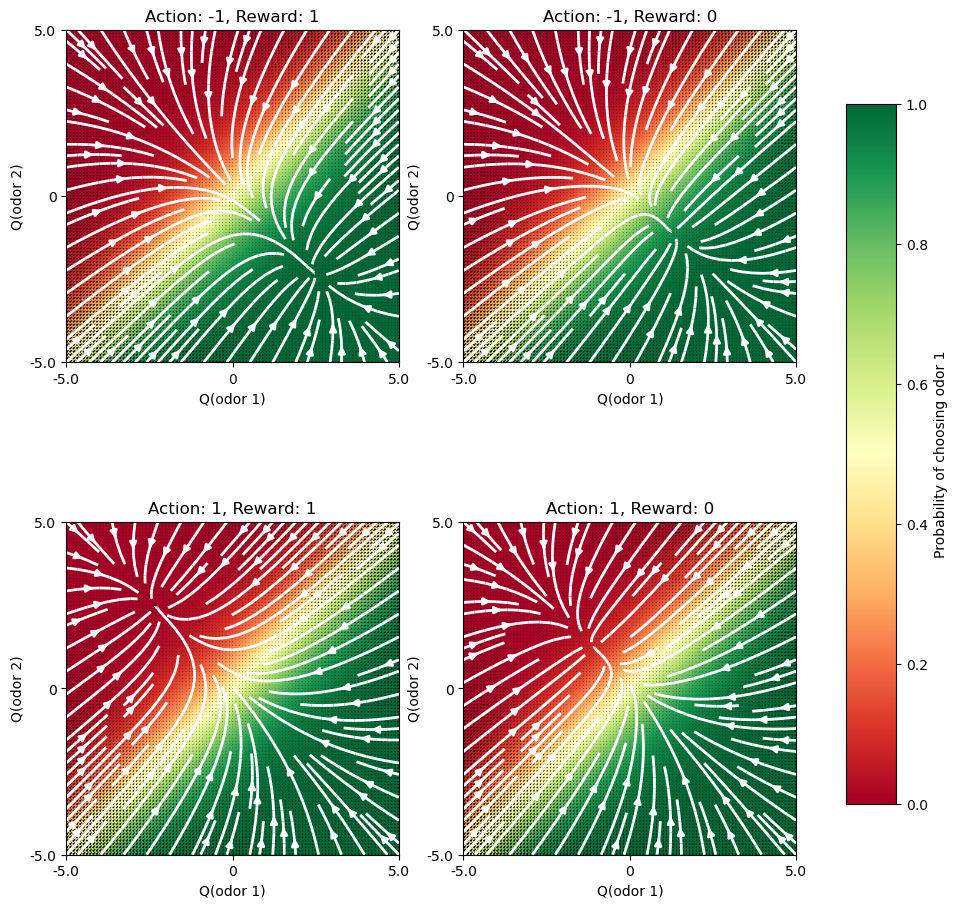

In [26]:
X,Y,_,_,z,AR = generate_GQNN_valuefield(sub_df,0,101,5,model_directory="//dm11/turnerlab/Rishika/modelfits/nn/softmax/")

mean_radius = np.mean((np.array(Us)**2 + np.array(Vs)**2)**0.5,axis=0)
variance = (np.mean(Us,axis=0)**2 + np.mean(Vs,axis=0)**2)**0.5/mean_radius

U = np.array(Us).mean(axis=0)/variance
V = np.array(Vs).mean(axis=0)/variance

plot_GQNN_valuefield(X,Y,U,V,z,AR)

In [27]:
np.linspace(-5,5,101)

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
       -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
       -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
       -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,
        0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
        2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
        3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,
        4.9,  5. ])

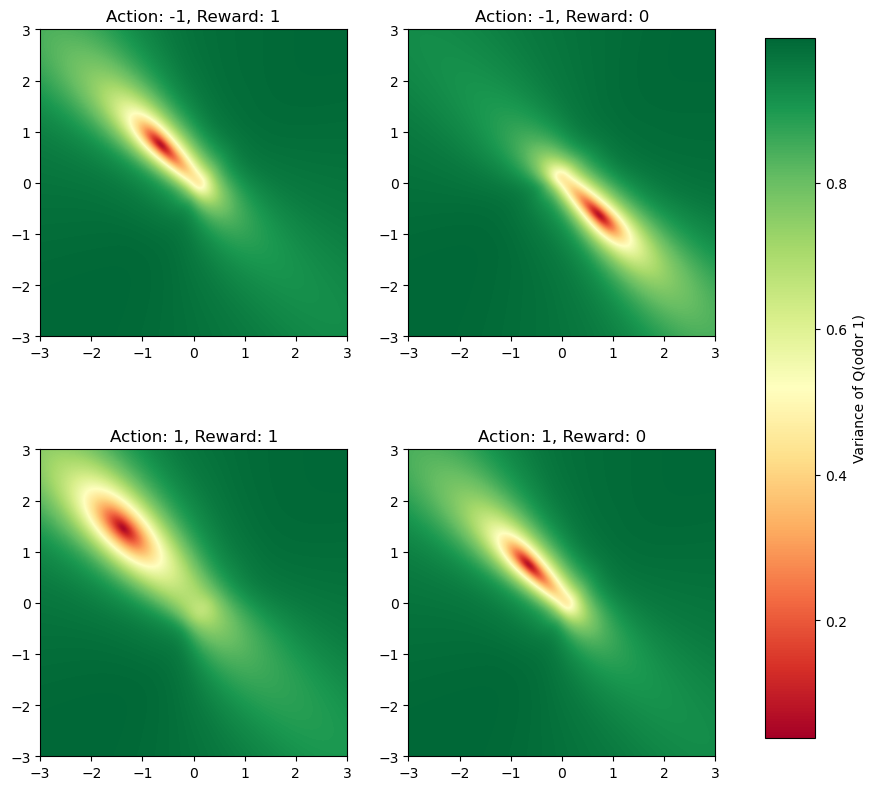

In [28]:
mean_radius = np.mean((np.array(Us)**2 + np.array(Vs)**2)**0.5,axis=0)
variance = (np.mean(Us,axis=0)**2 + np.mean(Vs,axis=0)**2)**0.5/mean_radius
# draw a 2x2 grid of plots
fig, ax = plt.subplots(2,2,figsize=(10,10))
for count,action_reward_pair in enumerate(AR):
    ax[count//2,count%2].imshow(variance[count],cmap='RdYlGn',interpolation='bicubic',extent=[-3,3,-3,3],origin='lower')
    ax[count//2,count%2].set_title(f"Action: {action_reward_pair[0]}, Reward: {action_reward_pair[1]}")
# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax.flatten()[0].imshow(variance[count],cmap='RdYlGn',interpolation='bicubic',extent=[-3,3,-3,3],origin='lower'), cax=cbar_ax, label="Variance of Q(odor 1)", orientation='vertical')

plt.show()

#### Find attractors given vector field

In [50]:
# setup interpolation on vector field
from scipy.interpolate import interp2d
from scipy.optimize import minimize,root_scalar

max_q = np.max([np.max(X),np.max(Y)])
resolution = len(X[0])

U = Us[0]
V = Vs[0]

attractor_populations = []
for i in range(4):
    attractor_population = []
    for j in tqdm(range(len(Us))):
        U = Us[j]
        V = Vs[j]
        # interpolate the vector field
        fU = interp2d(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution),U[i],kind='linear')
        fV = interp2d(np.linspace(-max_q,max_q,resolution),np.linspace(-max_q,max_q,resolution),V[i],kind='linear')
        norm = lambda x: (fU(x[0],x[1])**2 + fV(x[0],x[1])**2)[0]
        
        # minimize the norm of the vector field using gradient descent from random starting points
        for k in range(10):
            x0 = np.random.rand()*max_q*2 - max_q
            y0 = np.random.rand()*max_q*2 - max_q
            res = minimize(norm,(x0,y0),method='CG',options={'maxiter':1000})
            # check if the norm is less than epsilon
            if res.fun < 0.005:
                x0,y0 = res.x
                attractor_population.append((j,k,x0,y0,res.fun))
    attractor_populations.append(np.array(attractor_population))
    

100%|██████████| 6103/6103 [09:53<00:00, 10.28it/s]


In [51]:
cleaned_attractors = pd.DataFrame(columns=['ID','rep','x','y','condition','minima'])
for i in range(4):
    attractor_population = attractor_populations[i]
    for j in tqdm(range(len(attractor_population))):
        cleaned_attractors.loc[len(cleaned_attractors)] = [attractor_population[j][0],attractor_population[j][1],attractor_population[j][2],attractor_population[j][3],i,attractor_population[j][4]]

 85%|████████▍ | 25320/29959 [01:48<00:24, 187.35it/s]

In [ ]:
cleaned_attractors.ID

0            0.0
1            0.0
2            0.0
3            0.0
4            1.0
           ...  
171675    6102.0
171676    6102.0
171677    6102.0
171678    6102.0
171679    6102.0
Name: ID, Length: 171680, dtype: float64

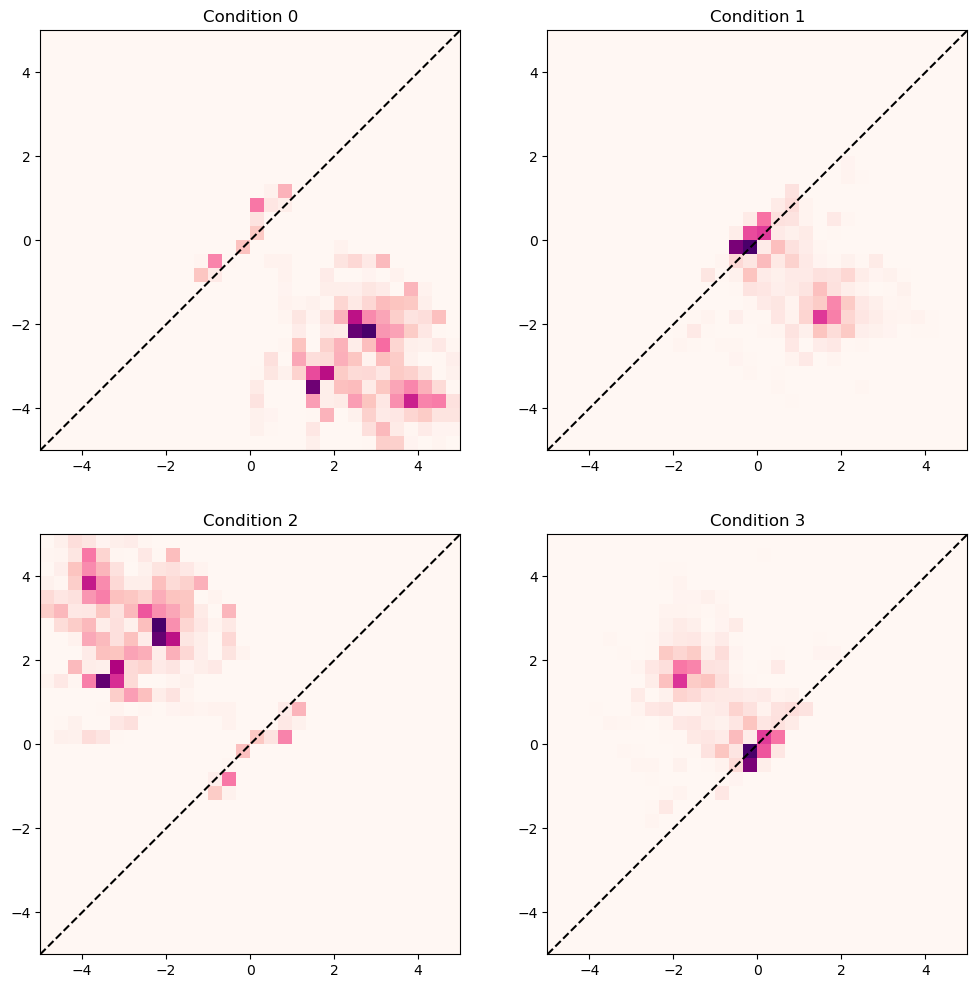

In [ ]:
top_10_percent = list(sub_df.sort_values(by='LogLikelihood(train)',ascending=False).index)[:int(0.5*len(sub_df))]
top_10_percent_attractors = cleaned_attractors[cleaned_attractors.ID.isin(top_10_percent)]
# create 2d histogram of the attractors for each condition
fig,ax = plt.subplots(2,2,figsize=(12,12))
for i in range(4):
    ax.flat[i].hist2d(top_10_percent_attractors[top_10_percent_attractors.condition==i].x,top_10_percent_attractors[top_10_percent_attractors.condition==i].y,bins=3\0,range=[[-max_q,max_q],[-max_q,max_q]],cmap='RdPu')
    ax.flat[i].set_xlim(-max_q,max_q)
    ax.flat[i].set_ylim(-max_q,max_q)
    ax.flat[i].set_title(f"Condition {i}")
    ax.flat[i].set_aspect('equal')
    # draw x=y line
    ax.flat[i].plot([-max_q,max_q],[-max_q,max_q],color='black',linestyle='--')
plt.show()

In [475]:
def generate_GQNN_attractorspace(dataset,index,max_q,model_directory="//dm11/turnerlab/Rishika/modelfits/nn/softmax/"):
    """
    A function to generate a vector field for a GQNN given the dataset+index and limits and resolution of the value field.
    """
    entry = dataset.iloc[index]
    model_id = entry['ModelID']
    model_type = entry['agent']
    path = entry['Model Path']
    model_path = model_directory + f"{model_id}/{path}.pt"

    env = ymaze_static(100, 0.5)

    # create learner parameters
    learner_params = {
        "allow_negative_values": True,
        "symmetric_q_function": entry['symmetric'],
        "omission_is_punishment": False,
        "policy_type": 'softmax',
        "device": 'cpu',
        "pre_trained": False,
        "model_path": None,
        "multi_agent": False,
        "n_agents": 1,
    }
    if model_type == "GQNN":
        learner_params["hidden_state_sizes"] = [int(x) for x in entry.hidden_state_sizes.split('x')]
        learner_params["activation"] = "relu"
        learner = GQLearner(env,learner_params)
    elif model_type == "GRNN":
        raise NotImplementedError("GRNN vector field generation is not possible yet.")

    # load model
    learner.load_pre_trained_model(model_path)

    omission = -1 if learner.omission_is_punishment else 0

    attractors = {
        0: [],
        1: [],
        2: [],
        3: [],
    }
    for count,action_reward_pair in enumerate([[-1,1],[-1,omission],[1,1],[1,omission]]):

        def norm(x):
            q_value = torch.tensor(np.array([[x[0],x[1]]]),dtype=torch.float)
            with torch.no_grad():
                q = learner.agent.forward(torch.tensor(np.repeat([action_reward_pair],1,axis=0),dtype=torch.float),q_value).cpu()-q_value
            u,v = q[0,0].cpu().detach().numpy(),q[0,1].cpu().detach().numpy()
            norm = (u**2 + v**2)
            return norm
        
        for j in range(1000):
            x0 = np.random.rand()*max_q*2 - max_q
            y0 = np.random.rand()*max_q*2 - max_q
            res = minimize(norm,(x0,y0),method='CG',options={'maxiter':1000})
            # check if the norm is less than epsilon
            if res.fun < 0.01:
                x0,y0 = res.x
                attractors[count].append((x0,y0,res.fun,index))
        
        attractors[count] = np.array(attractors[count])
    
    return attractors

# parallelize the attractor generation across 10 splits of the sub_df dataset
from joblib import Parallel, delayed
import multiprocessing

# generate the vector field for each model
attractors = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(generate_GQNN_attractorspace)(sub_df,i,max_q) for i in range(len(sub_df)))
np.savez_compressed("atrractors.npz",attractors=attractors)

In [24]:
# load the vector field
attractors = np.load("atrractors.npz",allow_pickle=True)['attractors']


In [116]:
cleaned_attractors = pd.DataFrame(columns=['ID','x','y','condition'])
for i in tqdm(range(len(attractors))):
    for j in range(4):
        temp = attractors[i][j]
        # get argmin of the norm
        if len(temp) > 0:
            argmin = np.argmin(temp[:,2])
            # get the attractor
            # cleaned_attractors = pd.concat([cleaned_attractors,pd.DataFrame([[i,temp[argmin][0],temp[argmin][1],j]],columns=['ID','x','y','condition'])])
            cleaned_attractors = pd.concat([cleaned_attractors,pd.DataFrame([[i,np.mean(temp,axis=0)[0],np.mean(temp,axis=0)[1],j]],columns=['ID','x','y','condition'])])
        else:
            cleaned_attractors = pd.concat([cleaned_attractors,pd.DataFrame([[i,np.NaN,np.NaN,j]],columns=['ID','x','y','condition'])])


100%|██████████| 13645/13645 [01:22<00:00, 165.36it/s]


In [115]:
np.mean(temp,axis=0)

array([-9.64068326e-02,  9.22719158e-01,  4.49350648e-03,  2.17700000e+03])

In [117]:
cleaned_attractors_drop = cleaned_attractors.dropna(axis=0)
top_10_percent = list(sub_df.sort_values(by='LogLikelihood(train)',ascending=False).index)[:int(0.1*len(sub_df))]
top_10_percent_attractors = cleaned_attractors_drop[cleaned_attractors_drop.ID.isin(top_10_percent)]

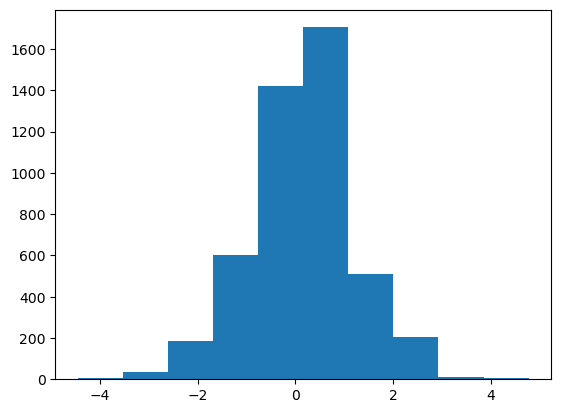

In [118]:
plt.hist(top_10_percent_attractors['x'])
plt.show()  

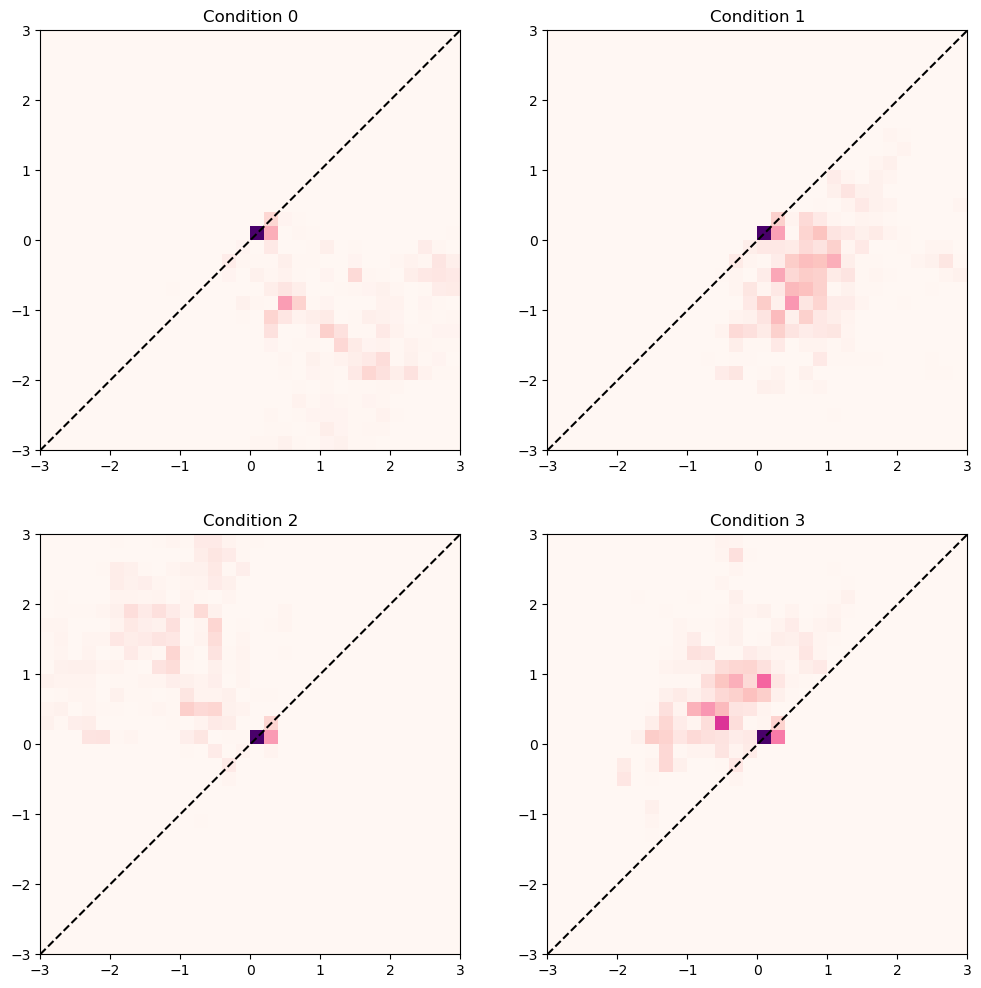

In [119]:
# create 2d histogram of the attractors for each condition
fig,ax = plt.subplots(2,2,figsize=(12,12))
for i in range(4):
    ax.flat[i].hist2d(top_10_percent_attractors[top_10_percent_attractors.condition==i].x,top_10_percent_attractors[top_10_percent_attractors.condition==i].y,bins=30,range=[[-max_q,max_q],[-max_q,max_q]],cmap='RdPu')
    ax.flat[i].set_xlim(-max_q,max_q)
    ax.flat[i].set_ylim(-max_q,max_q)
    ax.flat[i].set_title(f"Condition {i}")
    ax.flat[i].set_aspect('equal')
    # draw x=y line
    ax.flat[i].plot([-max_q,max_q],[-max_q,max_q],color='black',linestyle='--')

plt.show()

[10612,
 4223,
 13511,
 11085,
 763,
 12722,
 2727,
 10018,
 12721,
 641,
 11086,
 12120,
 998,
 12111,
 11092,
 12119,
 10988,
 11707,
 10022,
 10983,
 10019,
 12118,
 10297,
 10021,
 10027,
 10979,
 10613,
 12110,
 10990,
 10789,
 11093,
 11089,
 6112,
 10026,
 13451,
 10020,
 10985,
 10291,
 10978,
 10298,
 8026,
 9416,
 10993,
 11709,
 10995,
 11915,
 11001,
 5478,
 10986,
 10023,
 11589,
 11718,
 12325,
 13035,
 11704,
 10984,
 11863,
 9168,
 10257,
 1623,
 11624,
 10024,
 10300,
 11091,
 11703,
 11103,
 11913,
 13455,
 11921,
 13047,
 10293,
 11097,
 11924,
 12253,
 10790,
 13059,
 11094,
 11003,
 11095,
 10299,
 1951,
 10292,
 10028,
 10989,
 11720,
 10821,
 11705,
 11090,
 11088,
 12115,
 11096,
 11488,
 10997,
 13324,
 10539,
 13050,
 11714,
 12330,
 10827,
 13066,
 10537,
 5014,
 10991,
 11002,
 11712,
 11708,
 10029,
 11544,
 10987,
 13034,
 10290,
 11730,
 2631,
 13373,
 12117,
 9795,
 13064,
 11005,
 11726,
 10971,
 12328,
 13452,
 10972,
 9973,
 10030,
 11721,
 12116,
 11

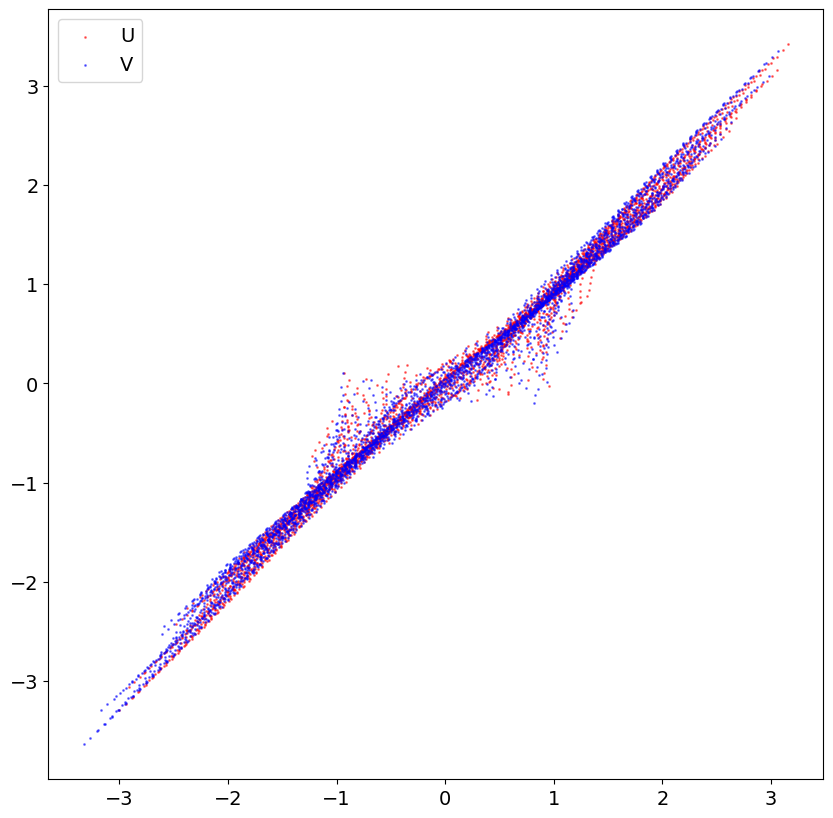

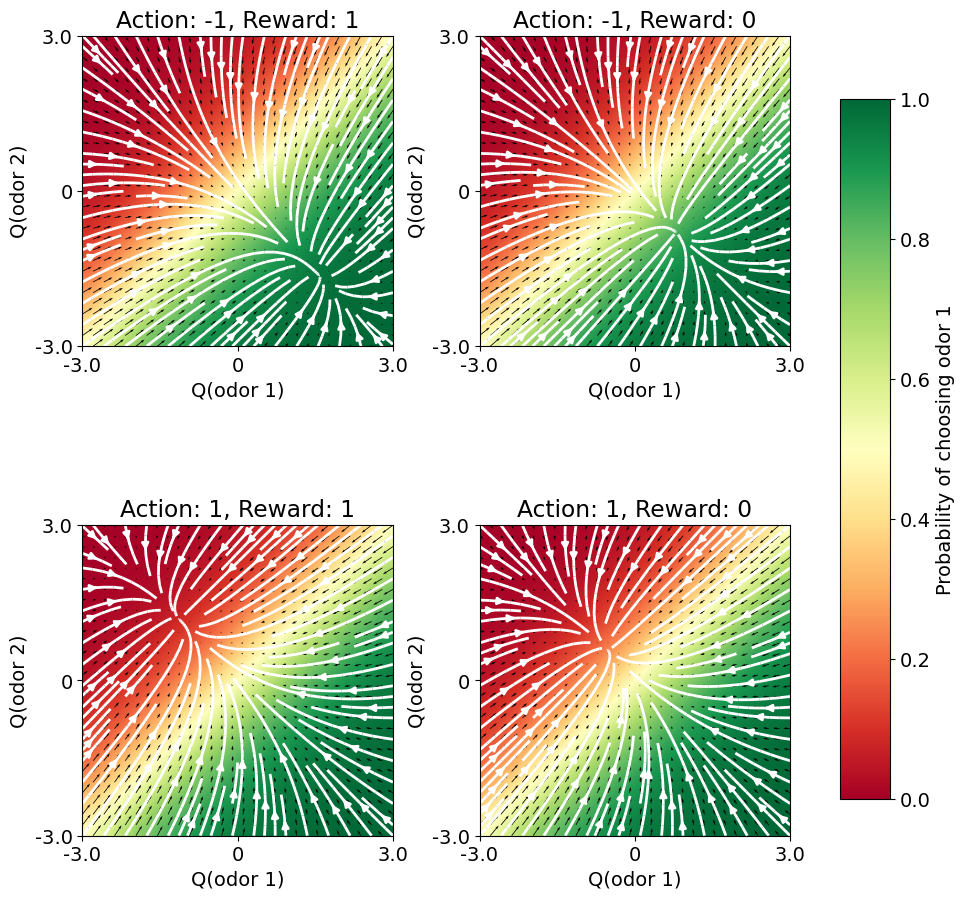

In [308]:
# code to fit linear regression to the data
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 2

# generate fitting data
X_data = []
Y_data = []
for i in range(4):
    X_ = np.array(X[i]).flatten().reshape(-1,1)
    Y_ = np.array(Y[i]).flatten().reshape(-1,1)
    U_ = np.array(U[i]).flatten().reshape(-1,1)
    V_ = np.array(V[i]).flatten().reshape(-1,1)
    N = len(X_)
    temp = np.repeat(AR[i],N).reshape(2,N).T 
    AR_ = np.zeros((N,3))
    AR_[:,0] = np.int32(temp[:,0] == -1)
    AR_[:,1] = np.int32(temp[:,0] == 1)
    AR_[:,2] = temp[:,1]
    X_data.append(np.concatenate([X_,Y_,AR_],axis=1))
    Y_data.append(np.concatenate([U_,V_],axis=1))
X_data = np.concatenate(X_data,axis=0)
Y_data = np.concatenate(Y_data,axis=0)



# apply polynomial transformation to the X data using sklearn
poly_features = PolynomialFeatures(degree=poly_degree,include_bias=True,interaction_only=True)
X_data_poly = poly_features.fit_transform(X_data)

# perform sparse linear regression
from sklearn.linear_model import OrthogonalMatchingPursuit,Lasso

# model = OrthogonalMatchingPursuit(n_nonzero_coefs=10,fit_intercept=False)
model = Lasso(alpha=0.001,fit_intercept=False)
model.fit(X_data_poly,Y_data)

# plot the regression line
fig, ax = plt.subplots(1,1,figsize=(10,10))
X_data_poly_test = poly_features.fit_transform(X_data)
Y_pred = model.predict(X_data_poly_test)
plt.scatter(Y_data[:,0],Y_pred[:,0],c='r',label="U",s=1,alpha=0.5)
plt.scatter(Y_data[:,1],Y_pred[:,1],c='b',label="V",s=1,alpha=0.5)
plt.legend()
plt.show()

# transform the data back to the original space
U_,V_ = model.predict(X_data_poly).T
U_,V_ = np.array_split(U_,4),np.array_split(V_,4)
U_ = [np.reshape(u,(30,30)) for u in U_]
V_ = [np.reshape(v,(30,30)) for v in V_]

plot_GQNN_valuefield(X,Y,U_,V_,z,AR)

In [309]:
def rename_variables(feature_list,map_dict):
    for i in range(len(feature_list)):
        for j in map_dict.keys():
            feature_list[i] = feature_list[i].replace(j,map_dict[j])
    return feature_list
    
map_dict = {
    'x0' : 'Q(1)',
    'x1' : 'Q(2)',
    'x2' : 'C(1)',
    'x3' : 'C(2)',
    'x4' : 'R',
    '^' : '**'
}

features = rename_variables(poly_features.get_feature_names_out(),map_dict)

# Print the model equation
print("Model equation:")
for eqno in [1,2]:
    print(r"ΔQ{} = ".format(eqno),end='')
    for i in range(len(features)):
        if model.coef_[eqno-1][i] != 0:
            if i != 0:
                print(r" + ",end='')
            if model.coef_[eqno-1][i] > 0:
                print(r"{:.5f} ".format(model.coef_[eqno-1][i]),end='')
            else:
                print(r"{:.5f} ".format(model.coef_[eqno-1][i]),end='')
            print(r"{}".format(features[i]),end='')
    print()


Model equation:
ΔQ1 =  + -0.68188 Q(1) + -0.24870 Q(2) + 0.34464 C(1) + -0.20967 C(2) + 0.00213 Q(1) Q(2) + -0.01581 Q(1) C(2) + 0.02717 Q(1) R + -0.00964 Q(2) C(2) + -0.04404 Q(2) R + 0.21180 C(1) R + -0.18421 C(2) R
ΔQ2 =  + -0.25494 Q(1) + -0.68172 Q(2) + -0.34380 C(1) + 0.26943 C(2) + 0.00175 Q(1) Q(2) + -0.02257 Q(1) C(1) + -0.05028 Q(1) R + -0.02811 Q(2) C(1) + 0.02066 Q(2) R + -0.25642 C(1) R + 0.16949 C(2) R


In [295]:
poly_features.get_feature_names_out(),features

(array(['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2',
        'x0 x3', 'x0 x4', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x2^2',
        'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2'], dtype=object),
 array(['1', 'Q(1)', 'Q(2)', 'C(1)', 'C(2)', 'R', 'Q(1)**2', 'Q(1) Q(2)',
        'Q(1) C(1)', 'Q(1) C(2)', 'Q(1) R', 'Q(2)**2', 'Q(2) C(1)',
        'Q(2) C(2)', 'Q(2) R', 'C(1)**2', 'C(1) C(2)', 'C(1) R', 'C(2)**2',
        'C(2) R', 'R**2'], dtype=object))

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\rishika\projects\flymazerl\flymazerl\utils\visualization.py:202: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



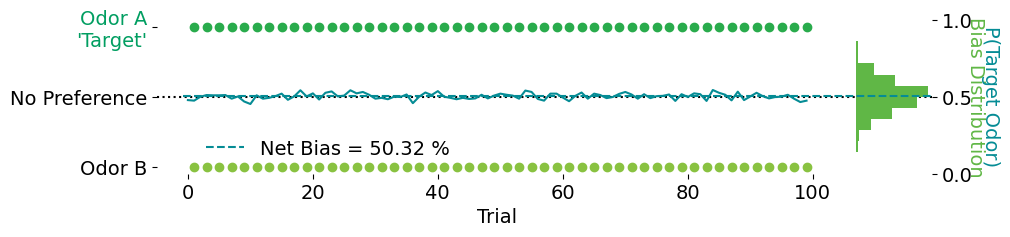

c:\ProgramData\Anaconda3\envs\flymazerl\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

c:\rishika\projects\flymazerl\flymazerl\utils\visualization.py:202: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



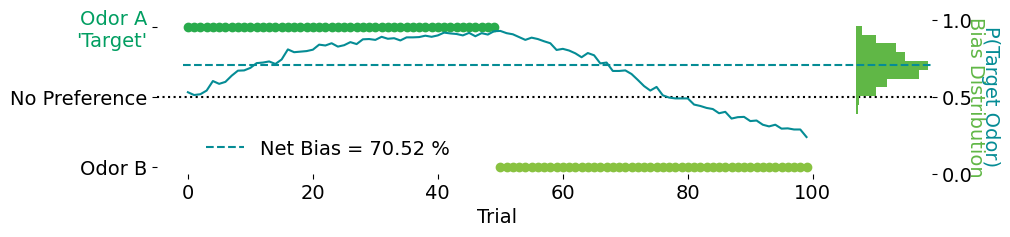

In [406]:
from flymazerl.agents.classical import CQLearner_acceptreject
from flymazerl.gym.environment import ymaze_static
from flymazerl.utils.generators import generate_params_from_fits,generate_random_schedule_with_blocks
from flymazerl.utils.evaluation import get_schedule_histories
from flymazerl.utils.visualization import draw_schedule

env1 = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,np.tile([0,1],50),np.tile([0,1],50)))
params,policy_params = generate_params_from_fits(CQLearner_acceptreject,1,sample_from_population=False)
histories = get_schedule_histories(env1,CQLearner_acceptreject,500,params,policy_params)
draw_schedule(env1.schedule,histories,save=True,filename="schedule_random_blocks.svg")

env2 = ymaze_static(100,schedule=generate_random_schedule_with_blocks(100,np.tile([1,0],1),np.tile([0,1],1)))
params,policy_params = generate_params_from_fits(CQLearner_acceptreject,1,sample_from_population=False)
histories = get_schedule_histories(env2,CQLearner_acceptreject,500,params,policy_params)
draw_schedule(env2.schedule,histories,save=True,filename="schedule_primed_blocks.svg")

In [283]:
np.repeat([0,1],N).reshape(-1,2)

array([[-3.        , -3.        ,  1.        ,  0.        ,  1.        ],
       [-2.79310345, -3.        ,  1.        ,  0.        ,  1.        ],
       [-2.5862069 , -3.        ,  1.        ,  0.        ,  1.        ],
       ...,
       [ 2.5862069 ,  3.        ,  0.        ,  1.        ,  0.        ],
       [ 2.79310345,  3.        ,  0.        ,  1.        ,  0.        ],
       [ 3.        ,  3.        ,  0.        ,  1.        ,  0.        ]])

In [396]:
np.tile([0,1],10)

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])